# Tutorial: scRNA-seq data

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `10k Human PBMCs, 3’ v3.1, Chromium Controller` (11,485 cells and 36,601 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Feature / cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/10k-human-pbmcs-3-v3-1-chromium-controller-3-1-high) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import screcode
import numpy as np
import scanpy as sc
import scipy
import pandas as pd 

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [2]:
input_filename = 'data/SC3pv3_GEX_Human_PBMC_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename)
adata.var_names_make_unique()
adata

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 5140 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

# Preprocessing

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

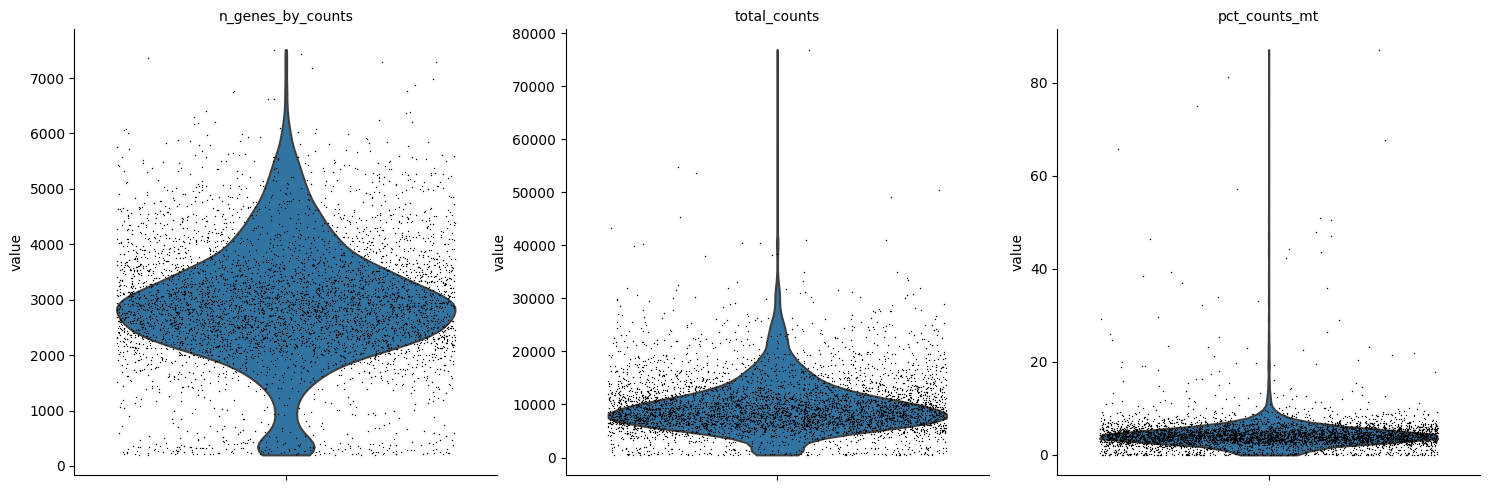

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)

In [6]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata

View of AnnData object with n_obs × n_vars = 4765 × 23729
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [7]:
adata_RECODE = adata.copy()
adata_RECODE

AnnData object with n_obs × n_vars = 4765 × 23729
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 17915, '#non-significant genes': 5814, '#silent genes': 0, 'ell': 326, 'Elapsed time': '0h 0m 40s 673ms', 'stat_learning': False, '#test_data': 953}


C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\screcode\screcode.py:736: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y=np.log10(norm_var[norm_var>0]), color='k',shade=True,ax=ax1)


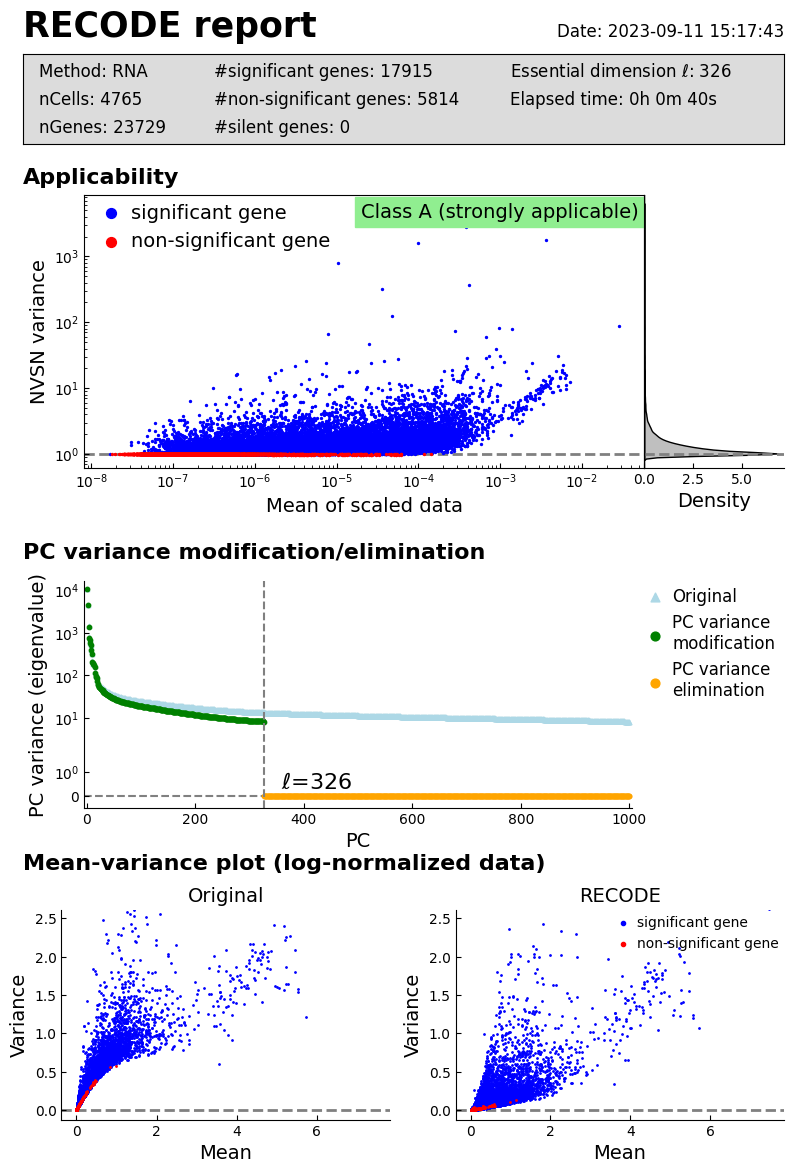

In [8]:
recode = screcode.RECODE()
adata_RECODE = recode.fit_transform(adata_RECODE)
recode.report()

# Downstream analysis by scanpy

In [41]:
if scipy.sparse.issparse(adata.X):
    adata.X = adata.X.toarray()
adata_RECODE.X = adata_RECODE.layers["RECODE"]

In [42]:
target_sum=1e4

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.normalize_total(adata_RECODE, target_sum=1e5)
sc.pp.log1p(adata_RECODE)

## PCA

In [43]:
sc.tl.pca(adata, svd_solver='arpack')
sc.tl.pca(adata_RECODE, svd_solver='arpack')

In [44]:
n_neighbors=15
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=None)
sc.tl.umap(adata)

In [45]:
sc.pp.neighbors(adata_RECODE, n_neighbors=n_neighbors, n_pcs=None)
sc.tl.umap(adata_RECODE)

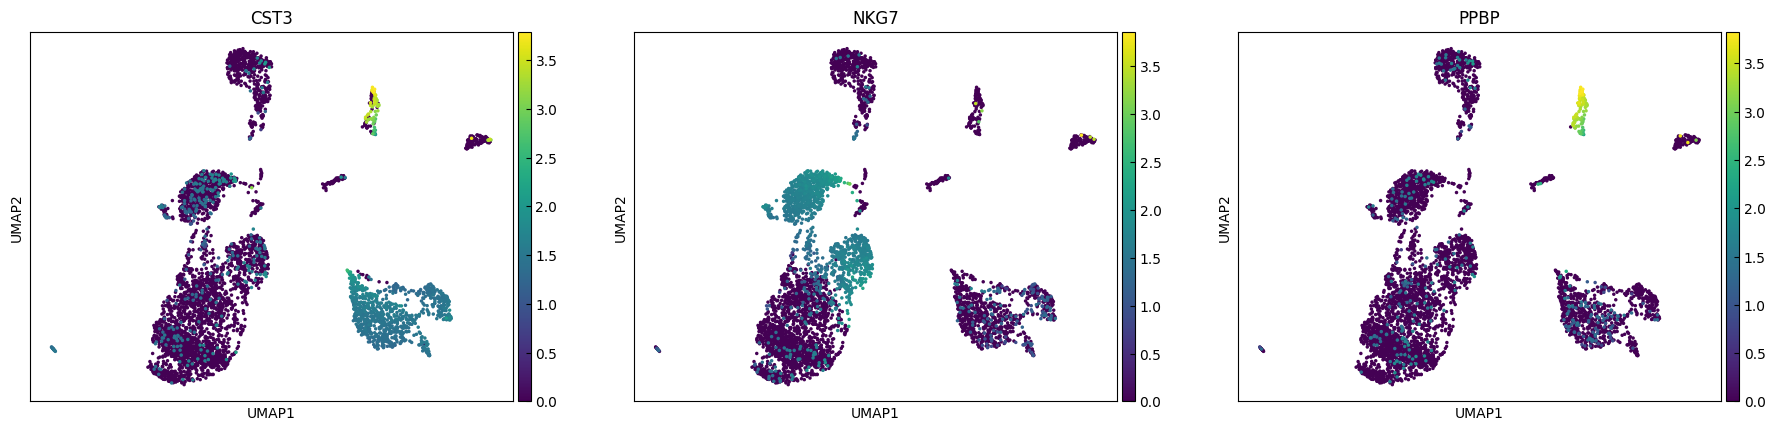

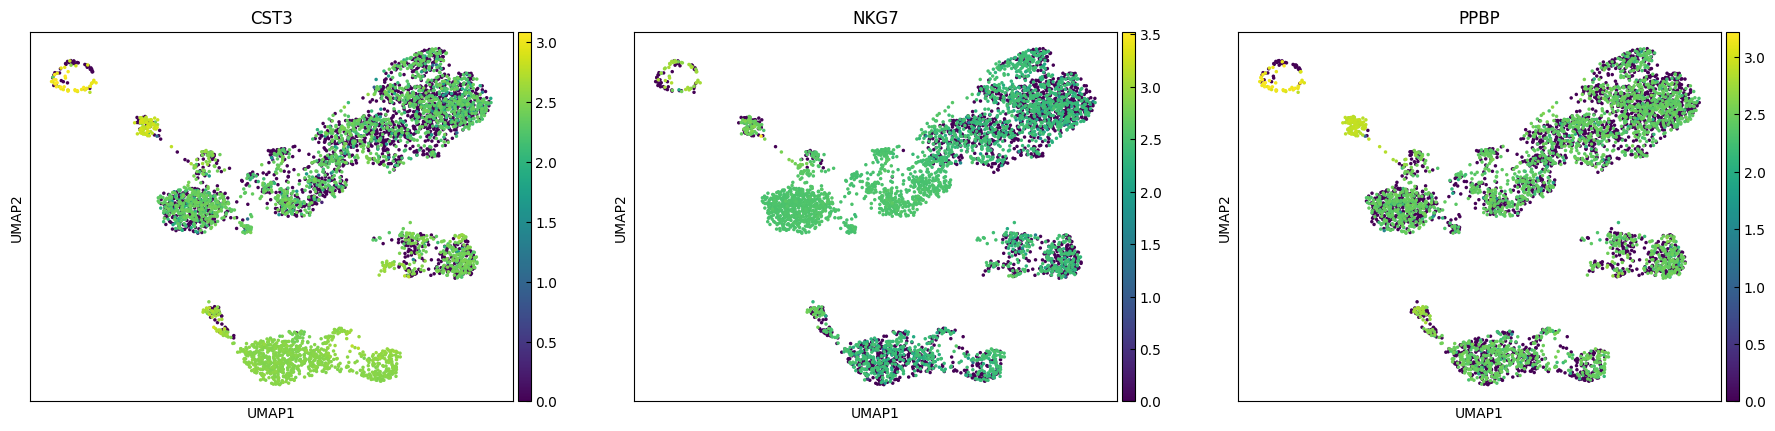

In [46]:
key_genes = ['CST3', 'NKG7', 'PPBP']
sc.pl.umap(adata, color=key_genes)
sc.pl.umap(adata_RECODE, color=key_genes)

In [47]:
sc.tl.leiden(adata)
sc.tl.leiden(adata_RECODE)

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


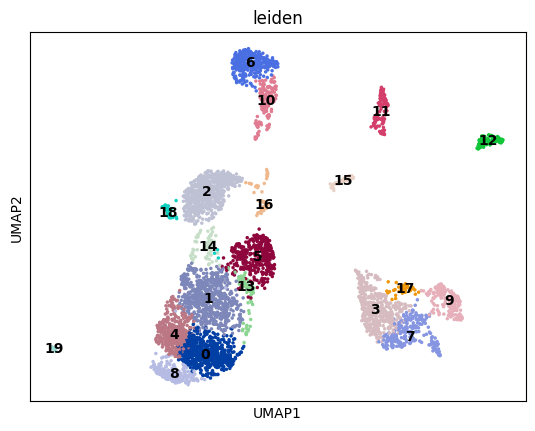

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


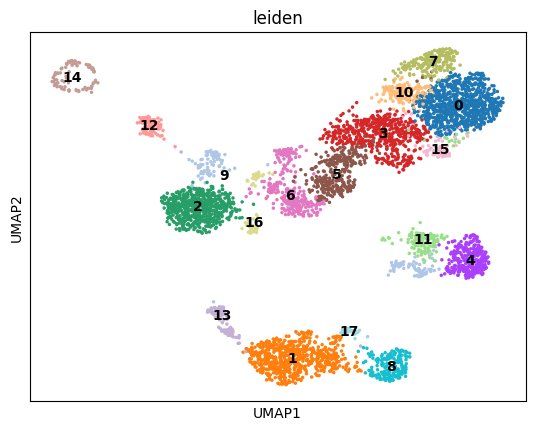

In [48]:
sc.pl.umap(adata, color=['leiden'],legend_loc="on data")
sc.pl.umap(adata_RECODE, color=['leiden'],legend_loc="on data")

In [49]:
clusters = adata.obs['leiden']
cluster_set = np.unique(clusters)
adata.uns["cluster_center"] = pd.DataFrame([np.mean(adata.X[clusters==c_],axis=0) for c_ in cluster_set],columns=adata.var.index,index=cluster_set)

clusters = adata_RECODE.obs['leiden']
cluster_set = np.unique(clusters)
adata_RECODE.uns["cluster_center"] = pd.DataFrame([np.mean(adata_RECODE.X[clusters==c_],axis=0) for c_ in cluster_set],columns=adata_RECODE.var.index,index=cluster_set)

In [50]:
pd_ = pd.concat([adata.uns["cluster_center"],adata_RECODE.uns["cluster_center"]])
pd_corr = pd_.T.corr()

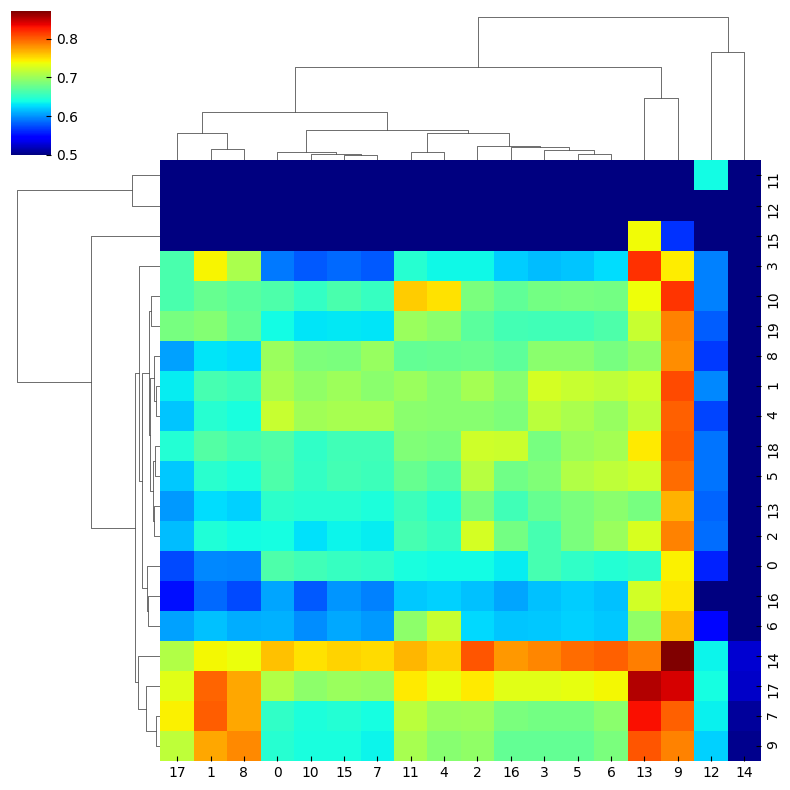

In [51]:
import seaborn as sns
# corr_ = np.corrcoef(adata.uns["cluster_center"],adata_RECODE.uns["cluster_center"])

# sns.clustermap(corr_[:adata.uns["cluster_center"].shape[0]][:,adata.uns["cluster_center"].shape[0]:],cmap="coolwarm",robust=True)
# fig,ax = plt.subplots(figsize=(8,8))
sns.clustermap(pd_corr[:adata.uns["cluster_center"].shape[0]].T[adata.uns["cluster_center"].shape[0]:].T,cmap="jet",vmin=0.5,figsize=(8,8))


C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


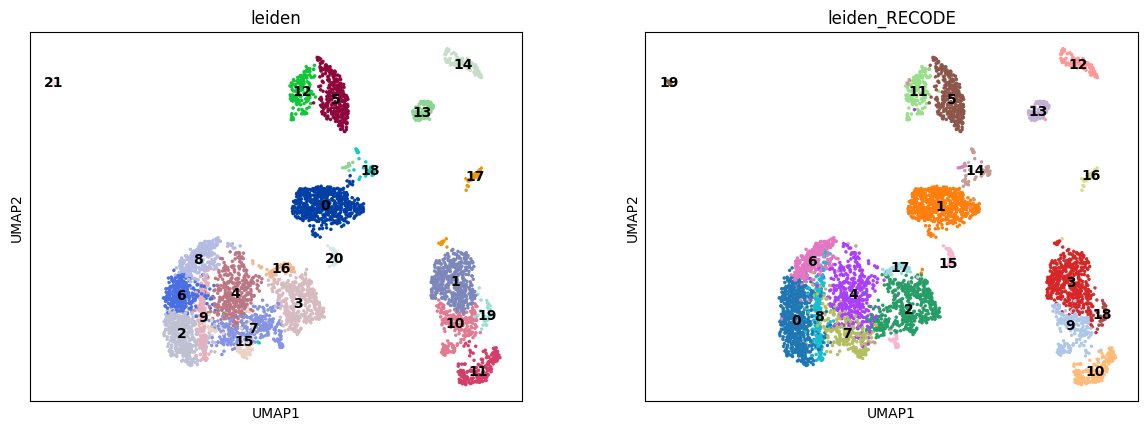

C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\expou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


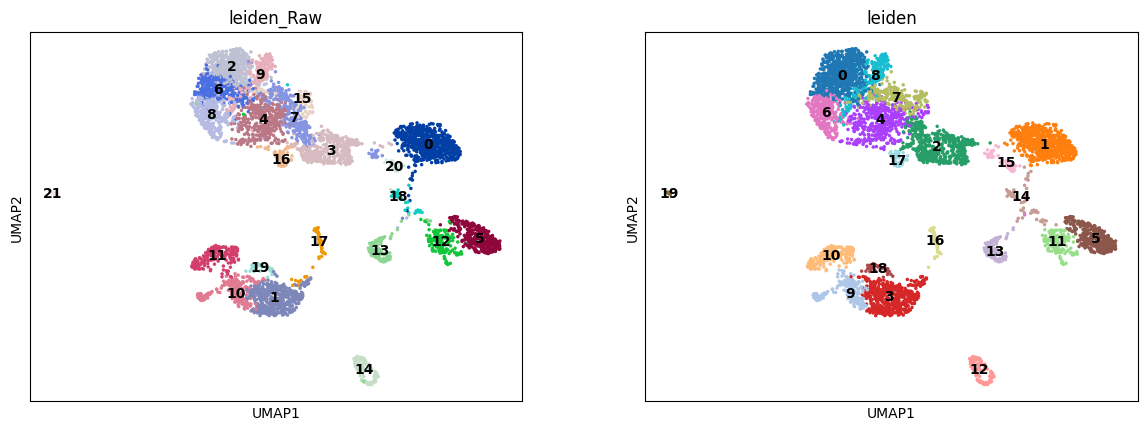

In [38]:
adata.obs['leiden_RECODE'] = adata_RECODE.obs['leiden']
sc.pl.umap(adata, color=['leiden','leiden_RECODE'],legend_loc="on data")


adata_RECODE.obs['leiden_Raw'] = adata.obs['leiden']
sc.pl.umap(adata_RECODE, color=['leiden_Raw','leiden'],legend_loc="on data")

In [ ]:
sc.pl.umap(adata, color=['leiden','STMN1'])
sc.pl.umap(adata_RECODE, color=['leiden','IL3RA','GAB2'])

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.tl.rank_genes_groups(adata_RECODE, 'leiden', method='t-test')

In [ ]:
cluster_nmbr = 11
for i in range(25):
    print(adata_RECODE.uns["rank_genes_groups"]["names"][i][cluster_nmbr])

In [ ]:
marker_genes = (list(adata.uns["rank_genes_groups"]["names"][0]))
sc.pl.dotplot(adata, marker_genes, groupby='leiden',expression_cutoff=1)

In [ ]:
marker_genes_RECODE = (list(adata_RECODE.uns["rank_genes_groups"]["names"][0]))
sc.pl.dotplot(adata_RECODE, marker_genes_RECODE, groupby='leiden',expression_cutoff=1)

regev_lab_cell_cycle_genes.txt is abailable [here](https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt)

In [ ]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
sc.tl.score_genes_cell_cycle(adata_RECODE, s_genes=s_genes, g2m_genes=g2m_genes)

In [ ]:
ps = 1
clusters = adata_RECODE.obs.phase.values
plot_data = adata_RECODE.obsm["X_umap"]
fig = plt.figure(figsize=(5,5))
for c_ in np.unique(clusters):
    idx_ = clusters == c_
    plt.scatter(plot_data[idx_,0],plot_data[idx_,1],s=ps,label=c_)
plt.legend()

In [ ]:
adata.X.toarray()[:,adata.var.index==marker_genes[i]]

In [ ]:
i = 0
for g_ in marker_genes:
    plt.figure(figsize=(5,5))
    plt.scatter(adata.X.toarray()[:,adata.var.index==g_],adata_RECODE.X[:,adata.var.index==g_],s=1)

In [ ]:
adata.obs["leiden"]

In [ ]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5
import seaborn as sns

def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    # cell_type = "_".join(group_key.split("_")[1:])
    cell_type = group_key
    result = sc.get.rank_genes_groups_df(adata, group=cell_type).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()

sc.tl.rank_genes_groups(adata, groupby="leiden")
for i in range(5):
    volcano_plot(adata, group_key=str(i), group_name="leiden")

sc.tl.rank_genes_groups(adata_RECODE, groupby="leiden")
for i in range(5):
    volcano_plot(adata_RECODE, group_key=str(i), group_name="leiden")

In [ ]:
import matplotlib.pyplot as plt


size_factor = 1e5
alpha = 0.2
plot_data = [np.log(size_factor*adata.X.toarray().T/np.sum(adata.X.toarray(),axis=1)+1).T,
            np.log(size_factor*adata_RECODE.layers['RECODE'].T/np.sum(adata_RECODE.layers['RECODE'],axis=1)+1).T]
names = ['Original','RECODE']

def plot_scatter(plot_data,names,genes):
    n_ax = len(plot_data)
    fig,ax = plt.subplots(1,n_ax,figsize=(5*n_ax,5),tight_layout=True)
    for i in range(n_ax):
        ax[i].scatter(plot_data[i][:,adata.var.index==genes[0]], plot_data[i][:,adata.var.index==genes[1]], alpha=alpha,zorder=10,color="gray")
        ax[i].set_xlabel(genes[0])
        ax[i].set_ylabel(genes[1])
        ax[i].set_title(names[i])
        ax[i].grid(ls='--',color='gray',zorder=0)

plot_scatter(plot_data,names,genes = ['CD19','CD3D'])
plot_scatter(plot_data,names,genes = ['CD4','CD8A'])